# Colab setup

In [1]:
from IPython.display import clear_output

In [2]:
import sys
if 'google.colab' in str(get_ipython()):
    ! {sys.executable} -m pip install pytorch-lifestream
    ! {sys.executable} -m pip install -U 'torch<2'  # downgrade for ptls==0.5.x
    ! {sys.executable} -m pip install -U 'pytorch-lightning<2'  # downgrade for ptls==0.5.x
    ! {sys.executable} -m pip install -U 'torchvision<0.15.1'  # downgrade for ptls==0.5.x
    ! {sys.executable} -m pip install -U 'torchaudio<2'  # downgrade for ptls==0.5.x

clear_output()

## Data load

In [3]:
import os

if not os.path.exists('data/transactions_train.csv'):
    ! mkdir -p data
    ! curl -OL https://storage.yandexcloud.net/ptls-datasets/age-prediction-nti-sbebank-2019.zip
    ! unzip -j -o age-prediction-nti-sbebank-2019.zip 'data/*.csv' -d data
    ! mv age-prediction-nti-sbebank-2019.zip data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  239M  100  239M    0     0  8774k      0  0:00:27  0:00:27 --:--:-- 10.0M
Archive:  age-prediction-nti-sbebank-2019.zip
  inflating: data/test.csv           
  inflating: data/small_group_description.csv  
  inflating: data/train_target.csv   
  inflating: data/transactions_train.csv  
  inflating: data/transactions_test.csv  


## Setup

In [4]:
%load_ext autoreload
%autoreload 2

# import logging
import torch
import pytorch_lightning as pl
# import warnings

# warnings.filterwarnings('ignore')
# logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

## Data preproccessing

In [5]:
import os
import pandas as pd

data_path = 'data/'

source_data = pd.read_csv(os.path.join(data_path, 'transactions_train.csv'))
source_data.head(2)

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017


In [6]:
from ptls.preprocessing import PandasDataPreprocessor

preprocessor = PandasDataPreprocessor(
    col_id='client_id',
    col_event_time='trans_date',
    event_time_transformation='none',
    cols_category=['small_group'],
    cols_numerical=['amount_rur'],
    return_records=True,
)

In [7]:
%%time

dataset = preprocessor.fit_transform(source_data)

CPU times: user 1min 4s, sys: 15.1 s, total: 1min 19s
Wall time: 1min 23s


In [8]:
import pickle

with open('preprocessor.p', 'wb') as f:
    pickle.dump(preprocessor, f)

In [9]:
dataset = sorted(dataset, key=lambda x: x['client_id'])

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2, random_state=42)

len(train), len(test)

(24000, 6000)

In [11]:
train[0].keys()

dict_keys(['client_id', 'trans_date', 'event_time', 'small_group', 'amount_rur'])

## Embedding training

Model training in our framework organised via pytorch-lightning (pl) framework.
The key parts of neural networks training in pl are:

    * model (`pytorch_lightning.LightningModule`)
    * data loader (`torch.utils.data.DataLoader`)
    * trainer (`pytorch_lightning.Trainer`)
    
For futher details check https://pytorchlightning.ai/

### Model definition

In [12]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.bert import RtdModule

trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount_rur': 'identity'},
    embeddings={
        # It is better to remove trans_date,
        # since using the date it is easy to notice the replacement in the sequence
        #'trans_date': {'in': 800, 'out': 16},
        'small_group': {'in': 250, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=64,
    type='gru',
)

model = RtdModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### Data loader

In [13]:
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.frames.bert import RtdDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule

train_dl = PtlsDataModule(
    train_data=RtdDataset(
        MemoryMapDataset(
            data=train,
            i_filters=[
                SeqLenFilter(min_seq_len=25),
            ],
        ),
        min_len = 600,
        max_len = 600,
    ),
    train_num_workers=2,
    train_batch_size=256,
)

### Trainer

In [14]:
import torch
import pytorch_lightning as pl

import logging

trainer = pl.Trainer(
    max_epochs=50,
    gpus=1 if torch.cuda.is_available() else 0,
    enable_progress_bar=False,
)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Training

In [15]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(


logger.version = 0


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type          | Params
-----------------------------------------------------
0 | _loss              | BCELoss       | 0     
1 | _seq_encoder       | RnnSeqEncoder | 20.0 K
2 | _validation_metric | AUROC         | 0     
3 | _head              | Sequential    | 65    
-----------------------------------------------------
20.1 K    Trainable params
0         Non-trainable params
20.1 K    Total params
0.080     Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


{'loss': tensor(0.3613), 'seq_len': tensor(600.)}
CPU times: user 3min 40s, sys: 22.3 s, total: 4min 2s
Wall time: 7min 23s


### Save sequence encoder for other experiments

In [16]:
torch.save(seq_encoder.state_dict(), "rtd-emb.pt")

## Inference


In [17]:
from ptls.data_load.utils import collate_feature_dict

In [18]:
import numpy as np
import torch
from collections import defaultdict
from functools import reduce

from ptls.data_load.feature_dict import FeatureDict
from ptls.data_load.padded_batch import PaddedBatch

from transformers.tokenization_utils_base import BatchEncoding

In [19]:
inference_data = train[:3000]

In [20]:
inference_dataset = MemoryMapDataset(
    data=inference_data,
)

In [21]:
inference_dl = torch.utils.data.DataLoader(
    dataset=inference_dataset,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=32,
    num_workers=2,
)
#padded_batch = next(iter(inference_dl)).payload

In [22]:
from ptls.frames.inference_module import InferenceModule
from ptls.data_load.padded_batch import PaddedBatch
from itertools import chain

In [27]:
inference_module = InferenceModule(
    model=seq_encoder,
    pandas_output=True,
    drop_seq_features=False,
    model_out_name='emb')

In [28]:
inference_module.model.seq_encoder.is_reduce_sequence = False

In [29]:
predict = pl.Trainer(gpus=1).predict(inference_module, inference_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [30]:
full_predict = pd.concat(predict, axis=0)
full_predict.shape

(2646251, 69)

In [31]:
full_predict.head()

,client_id,trans_date,event_time,small_group,amount_rur,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,...,emb_0054,emb_0055,emb_0056,emb_0057,emb_0058,emb_0059,emb_0060,emb_0061,emb_0062,emb_0063
0,36253,0,0,1,40.756,0.665921,0.906752,0.168844,-0.974993,0.371013,...,0.398054,0.701928,0.150014,-0.184834,-0.202624,-0.044519,0.626754,0.944769,-0.783068,0.777406
1,36253,1,1,1,40.413,-0.201294,0.965426,0.250792,-0.996656,0.352793,...,0.529100,0.722080,0.798705,0.249999,-0.107270,0.194447,0.638224,0.805327,-0.628129,0.764504
2,36253,2,2,1,36.788,0.131511,0.989204,0.265504,-0.998135,0.321147,...,0.307743,0.743951,0.823414,0.288865,-0.208770,0.149822,0.632004,0.736532,-0.664531,0.800193
3,36253,3,3,11,212.640,-0.350597,0.999114,0.059446,-0.930354,0.318071,...,-0.150084,0.744923,0.998247,0.893118,-0.990629,0.569958,0.633822,0.628379,-0.916929,-0.788023
4,36253,3,3,31,255.538,0.059787,0.999964,-0.315022,-0.896436,0.322367,...,-0.132178,0.742905,0.999975,0.990725,-0.997930,0.692984,0.609294,0.595716,-0.977947,-0.986293


In [32]:
vecs = full_predict.loc[full_predict['client_id'].isin([1187, 36253, 396, 38243, 1002])]

In [33]:
cols_to_drop = ['client_id',
                'trans_date',
                'event_time',
                'small_group',
                'amount_rur']

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=250, metric="cosine")
embs = tsne.fit_transform(vecs.drop(columns=cols_to_drop))

In [35]:
vecs['x'] = embs[:, 0]
vecs['y'] = embs[:, 1]

<ipython-input-35-6d69180b3521>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vecs['x'] = embs[:, 0]
<ipython-input-35-6d69180b3521>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vecs['y'] = embs[:, 1]


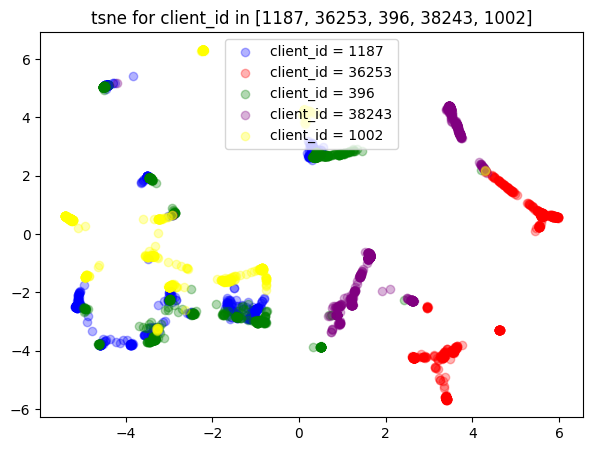

In [36]:
from matplotlib import pyplot as plt
FS = (7, 5)
fig, ax = plt.subplots(figsize=FS)
users = [1187, 36253, 396, 38243, 1002]
colors = ['b', 'r', 'g', 'purple', 'yellow', 'brown']
for usr, clr in zip(users, colors):
    ax.scatter(vecs.loc[vecs['client_id'] == usr].x,
               vecs.loc[vecs['client_id'] == usr].y,
               alpha=.3,
               color = clr,
               label = f'client_id = {usr}')
ax.set_title('tsne for client_id in [1187, 36253, 396, 38243, 1002]')
ax.legend()

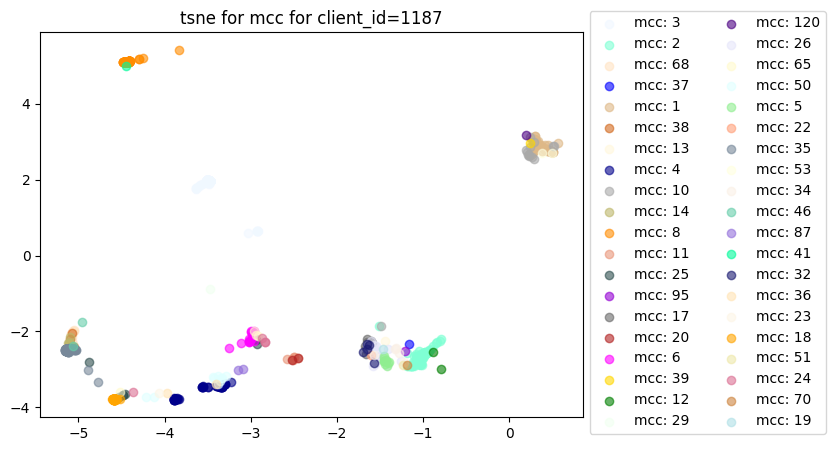

In [37]:
import matplotlib.colors as colors
FS = (7, 5)
mccs = vecs[vecs['client_id'] == 1187].small_group.unique()
colors_list = list(colors.cnames.values())
fig, ax = plt.subplots(figsize=FS)
clr = 0
for mcc in mccs:
    ax.scatter(vecs.loc[(vecs['client_id'] == 1187) & (vecs['small_group'] == mcc)].x,
               vecs.loc[(vecs['client_id'] == 1187) & (vecs['small_group'] == mcc)].y,
               alpha = .6,
               color = colors_list[clr],
               label = f'mcc: {mcc}')
    clr += len(colors_list)//len(mccs)
ax.set_title('tsne for mcc for client_id=1187')
ax.legend(ncols = 2,
          loc="center left",
          bbox_to_anchor=(0.9, 0.5),
          bbox_transform=fig.transFigure )

Text(0, 0.5, 'trans_date')

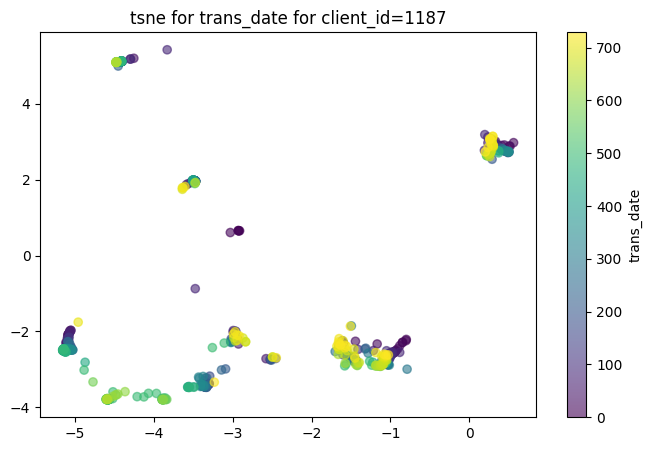

In [38]:
plt.figure(figsize=(8, 5))
plt.scatter(vecs.loc[(vecs['client_id'] == 1187)].x,
           vecs.loc[(vecs['client_id'] == 1187)].y,
           c = vecs.loc[(vecs['client_id'] == 1187)].trans_date,
           alpha = .6)
plt.title('tsne for trans_date for client_id=1187')
cbar = plt.colorbar()
cbar.ax.set_ylabel('trans_date')


Obtained embeddings can be used as features for model training

For example:

In [ ]:
X = full_predict.drop(columns = cols_to_drop)
y = full_predict['small_group']

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test = X.values[:100000], X.values[100000:120000]
y_train, y_test = y.values[1:100001], y.values[100001:120001]

In [ ]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(learning_rate = 0.01, random_state = 42)
clf.fit(X_train, y_train)
clear_output()

In [ ]:
from sklearn.metrics import accuracy_score
y_pred=clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.34875